In [1]:
%load_ext autoreload
%autoreload

import dolfinx
import numpy as np
import matplotlib.pyplot as plt
import dolfinx.fem.petsc
import pandas as pd
import scipy as sp
import eitx
import ufl

from petsc4py import PETSc #Linear algebra lib
print(PETSc.ScalarType)
assert np.dtype(PETSc.ScalarType).kind == 'c'



<class 'numpy.complex128'>


In [42]:
dirname = 'experiments/24-08-01'

# Setup with mesh Delaunay

Error   : Gmsh has not been initialized


Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 0.0663128s, CPU 0.035578s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Delaunay)
Info    : Done meshing 2D (Wall 0.25746s, CPU 0.242803s)
Info    : 3129 nodes 5457 elements


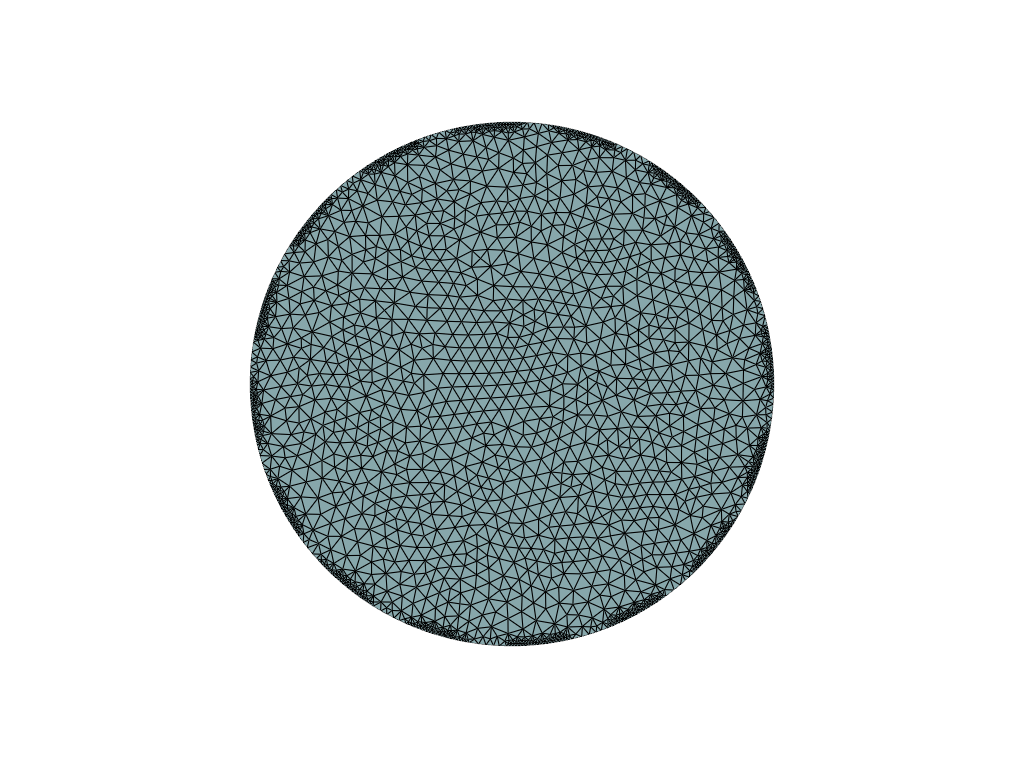

In [2]:
L=16
perc=0.5
electrodes = eitx.Electrodes(L,perc,0)

mesh_refining = 0.3 #scaling factor for all domain refinement
bdr_refining = 0.4 # scaling factor for border refining

mesh_object = eitx.MeshClass(electrodes,mesh_refining,bdr_refining)
mesh_dir = mesh_object.mesh
z_values = np.full(L,0.0025+0.0025j)
dir_problem = eitx.DirectProblem(mesh_object, z_values)
I_all = eitx.current_method(L,15,method=2,value=1)

eitx.plot_mesh(mesh_dir)

In [3]:
V0 = dir_problem.V0
x = ufl.SpatialCoordinate(mesh_dir)

#defining gamma
def gamma_locator(x):
  return (x[0]+0.3)**2 + (x[1]+0.3)**2<=0.3**2
def gamma_locator_2(x):
  return (x[0]-0.3)**2 + (x[1]-0.3)**2<=0.2**2
gamma_sol = dolfinx.fem.Function(V0)
gamma_sol_cells = gamma_locator(V0.tabulate_dof_coordinates().T).astype(int)
gamma_sol_cells2 = gamma_locator_2(V0.tabulate_dof_coordinates().T).astype(int)
gamma_sol.x.array[:] = 1 + 1j + gamma_sol_cells + 2j*gamma_sol_cells2
# gamma_sol = dolfinx.fem.Function(V0)
# expr = 1+1j+ ufl.exp(-(x[0]**2+x[1]**2)/0.2) + 1j*ufl.exp(-(x[0]**2+x[1]**2)/0.2)
# gamma_sol.interpolate(dolfinx.fem.Expression(expr,V0.element.interpolation_points()))

#solving direct problem
dir_problem.set_problem(gamma_sol)
u_list, U_list = dir_problem.solve_problem_current(I_all)

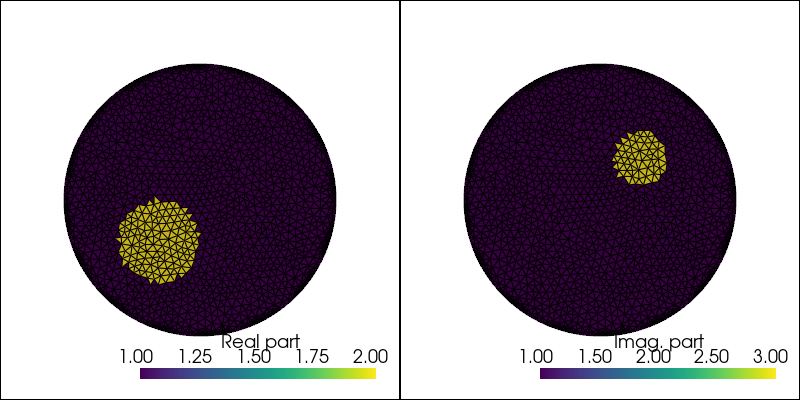

In [4]:
eitx.plot_indicator_function(gamma_sol)

Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 0.0466871s, CPU 0.046517s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Delaunay)
Info    : Done meshing 2D (Wall 0.0806689s, CPU 0.080995s)
Info    : 1748 nodes 2695 elements


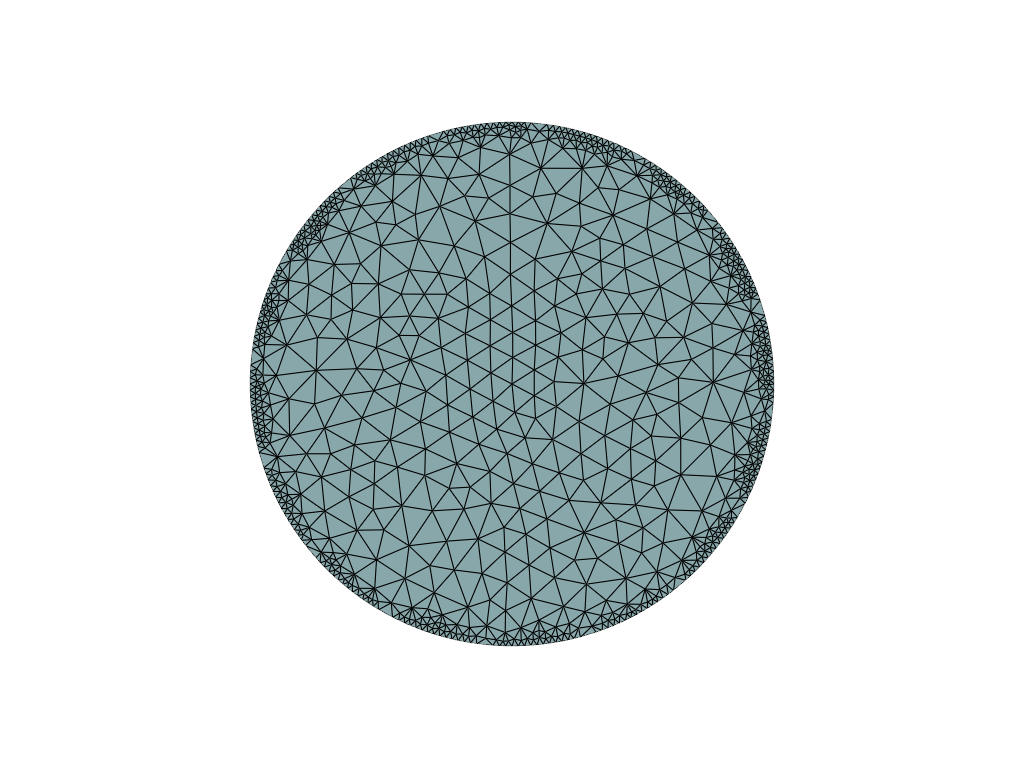

In [5]:
mesh_refining = 0.6 #scaling factor for all domain refinement
bdr_refining = 0.8 # scaling factor for border refining
mesh_inv_object = eitx.MeshClass(electrodes,mesh_refining,bdr_refining)
mesh = mesh_inv_object.mesh
eitx.plot_mesh(mesh)

In [6]:
A = np.ones((3,3)) @ np.diag([1,2,3])
np.diag(np.linalg.norm(A,axis=0))

array([[1.73205081, 0.        , 0.        ],
       [0.        , 3.46410162, 0.        ],
       [0.        , 0.        , 5.19615242]])

# Using Jacobian columns weights

## Landweber

In [34]:
%autoreload
import eitx
inv_problem = eitx.InverseProblem(mesh_inv_object, z_values, I_all)

In [45]:
solverconfig_dict= { 
    #General Parameters
    "inner_method": "Landweber",
    "step_limit": 100,
    "tau": 1,
    "noise_level": 0,
    "weight_value": True,
    "weight_type": "Area",
    "innerstep_limit": 1,
    "land_a": 0.275,
    #General newton method parameters
    "mu_i":0.85,
    "mu_max":0.999,
    "nu":0.97,
    "R":0.97,
}
inv_problem.set_solverconfig(**solverconfig_dict)
inv_problem.set_answer(gamma_sol)

In [46]:
gamma, res_array, err_array = inv_problem.solve_inverse(U_list)


starting outer step 1
Inner iteration finished with 1 iterations
starting outer step 2
Inner iteration finished with 1 iterations
starting outer step 3
Inner iteration finished with 1 iterations
starting outer step 4
Inner iteration finished with 1 iterations
starting outer step 5
Inner iteration finished with 1 iterations
starting outer step 6
Inner iteration finished with 1 iterations
starting outer step 7
Inner iteration finished with 1 iterations
starting outer step 8
Inner iteration finished with 1 iterations
starting outer step 9
Inner iteration finished with 1 iterations
starting outer step 10
Inner iteration finished with 1 iterations
starting outer step 11
Inner iteration finished with 1 iterations
starting outer step 12
Inner iteration finished with 1 iterations
starting outer step 13
Inner iteration finished with 1 iterations
starting outer step 14
Inner iteration finished with 1 iterations
starting outer step 15
Inner iteration finished with 1 iterations
starting outer step

In [47]:
err_array = np.array(err_array)
res_array = np.array(res_array)

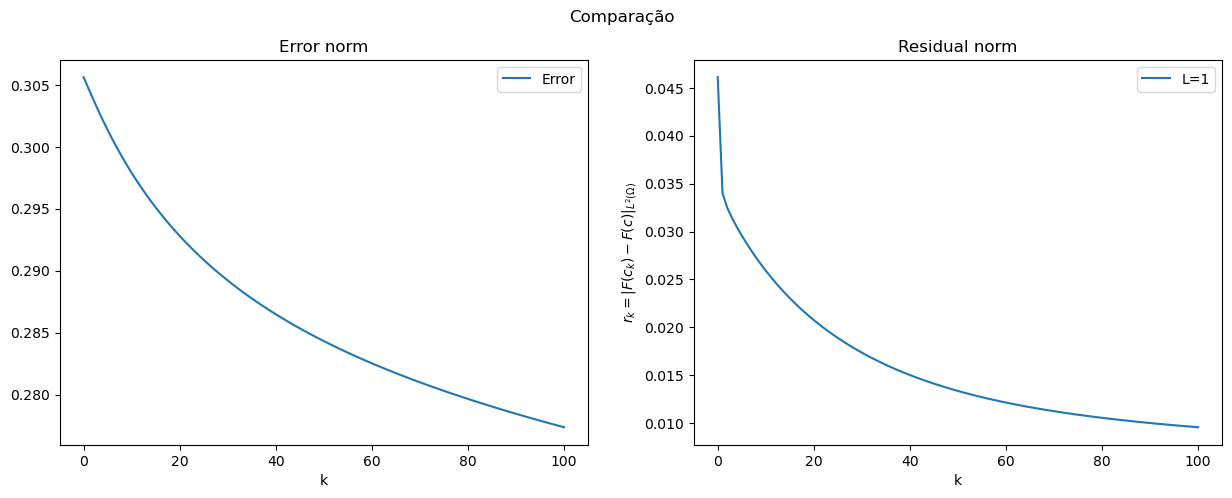

In [48]:
gamma_norm = dolfinx.fem.assemble_scalar(dolfinx.fem.form(ufl.inner(inv_problem.gamma_inv, inv_problem.gamma_inv)*ufl.dx)).real**0.5
U_norm = np.linalg.norm(np.array(U_list).flatten())

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(err_array/gamma_norm,label='Error')
ax[0].set_title("Error norm")
ax[0].set_xlabel("k")
# ax[0].set_yscale("log")
ax[0].legend()

ax[1].plot(res_array/U_norm,label ='L=1')
ax[1].set_title("Residual norm")
ax[1].set_ylabel("$r_k = \|F(c_k) - F(c)\|_{L^2(\Omega)}$")
ax[1].set_xlabel("k")
# ax[1].set_yscale("log")
ax[1].legend()

fig.suptitle("Comparação")
plt.savefig(dirname+'/lw-d1-graphs')
plt.show()

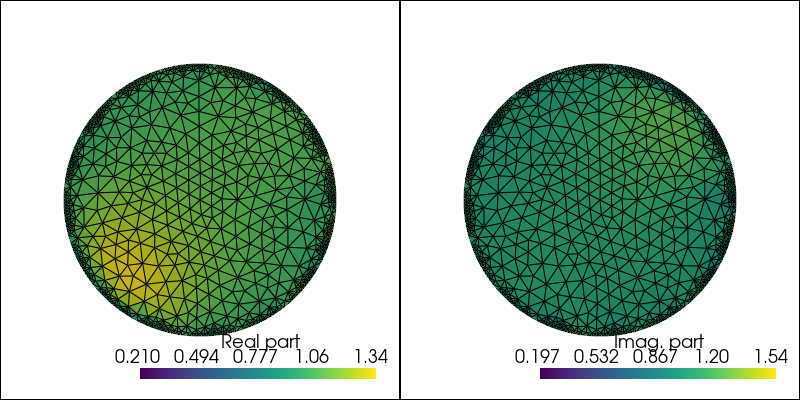

In [49]:
eitx.plot_indicator_function(gamma,savefile=True,filename=dirname+'/lw_d1-solution')

starting outer step 1
Inner iteration finished with 1 iterations
starting outer step 2
Inner iteration finished with 1 iterations
starting outer step 3
Inner iteration finished with 1 iterations
starting outer step 4
Inner iteration finished with 1 iterations
starting outer step 5
Inner iteration finished with 1 iterations
starting outer step 6
Inner iteration finished with 1 iterations
starting outer step 7
Inner iteration finished with 1 iterations
starting outer step 8
Inner iteration finished with 1 iterations
starting outer step 9
Inner iteration finished with 1 iterations
starting outer step 10
Inner iteration finished with 1 iterations
starting outer step 11
Inner iteration finished with 1 iterations
starting outer step 12
Inner iteration finished with 1 iterations
starting outer step 13
Inner iteration finished with 1 iterations
starting outer step 14
Inner iteration finished with 1 iterations
starting outer step 15
Inner iteration finished with 1 iterations
starting outer step

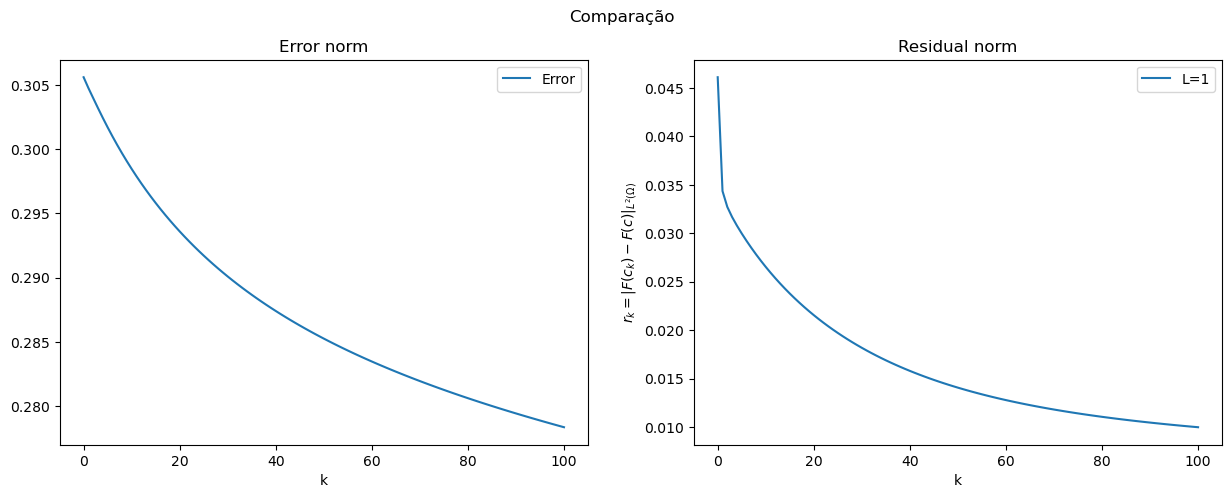

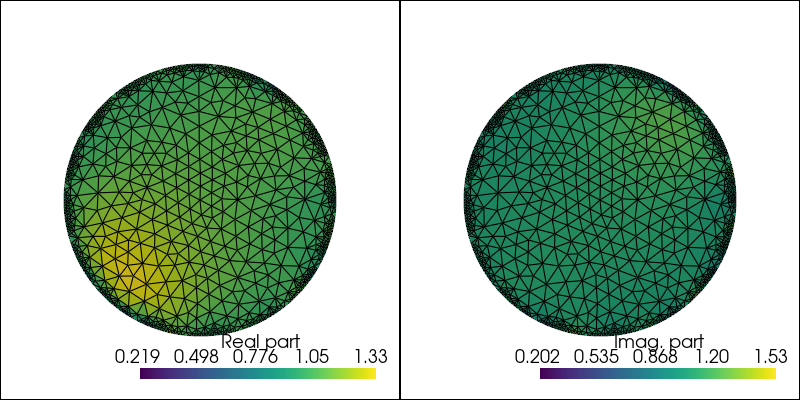

In [50]:
solverconfig_dict= { 
    #General Parameters
    "inner_method": "Landweber",
    "step_limit": 100,
    "tau": 1,
    "noise_level": 0,
    "weight_value": True,
    "weight_type": "Jacobian",
    "innerstep_limit": 1,
    "land_a": 0.25,
    #General newton method parameters
    "mu_i":0.85,
    "mu_max":0.999,
    "nu":0.97,
    "R":0.97,
}
inv_problem.set_solverconfig(**solverconfig_dict)
inv_problem.set_answer(gamma_sol)
gamma, res_array, err_array = inv_problem.solve_inverse(U_list)

err_array = np.array(err_array)
res_array = np.array(res_array)
gamma_norm = dolfinx.fem.assemble_scalar(dolfinx.fem.form(ufl.inner(inv_problem.gamma_inv, inv_problem.gamma_inv)*ufl.dx)).real**0.5
U_norm = np.linalg.norm(np.array(U_list).flatten())

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(err_array/gamma_norm,label='Error')
ax[0].set_title("Error norm")
ax[0].set_xlabel("k")
# ax[0].set_yscale("log")
ax[0].legend()

ax[1].plot(res_array/U_norm,label ='L=1')
ax[1].set_title("Residual norm")
ax[1].set_ylabel("$r_k = \|F(c_k) - F(c)\|_{L^2(\Omega)}$")
ax[1].set_xlabel("k")
# ax[1].set_yscale("log")
ax[1].legend()

fig.suptitle("Comparação")
plt.savefig(dirname+"/lw-d2-graphs.png")
plt.show()
eitx.plot_indicator_function(gamma,savefile=True,filename=dirname+'/lw-d2-solution')

## Levenberg-Marquardt

In [18]:
%autoreload
import eitx
inv_problem = eitx.InverseProblem(mesh_inv_object, z_values, I_all)

In [19]:
solverconfig_dict= { 
    #General Parameters
    "inner_method": "Tikhonov",
    "step_limit": 10,
    "tau": 1,
    "noise_level": 0,
    "weight_value": True,
    "innerstep_limit": 1,
    "Tik_c0": 1e-6,
    "Tik_q": 1,
    #General newton method parameters
    "mu_i":0.85,
    "mu_max":0.999,
    "nu":0.97,
    "R":0.97,
}
inv_problem.set_solverconfig(**solverconfig_dict)
inv_problem.set_answer(gamma_sol)

In [20]:
gamma, res_array, err_array = inv_problem.solve_inverse(U_list)


starting outer step 1
Inner iteration finished with 1 iterations
starting outer step 2
Inner iteration finished with 1 iterations
starting outer step 3
Inner iteration finished with 1 iterations
starting outer step 4
Inner iteration finished with 1 iterations
starting outer step 5
Inner iteration finished with 1 iterations
starting outer step 6
Inner iteration finished with 1 iterations
starting outer step 7
Inner iteration finished with 1 iterations
starting outer step 8
Inner iteration finished with 1 iterations
starting outer step 9
Inner iteration finished with 1 iterations
starting outer step 10
Inner iteration finished with 1 iterations


In [21]:
err_array = np.array(err_array)
res_array = np.array(res_array)

Text(0.5, 0.98, 'Comparação')

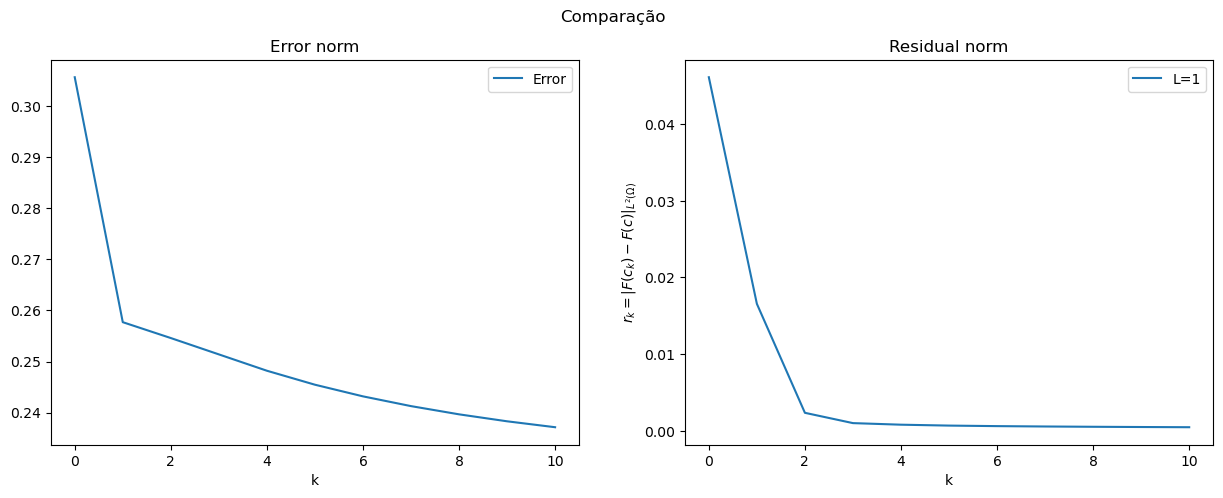

In [22]:
gamma_norm = dolfinx.fem.assemble_scalar(dolfinx.fem.form(ufl.inner(inv_problem.gamma_inv, inv_problem.gamma_inv)*ufl.dx)).real**0.5
U_norm = np.linalg.norm(np.array(U_list).flatten())

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(err_array/gamma_norm,label='Error')
ax[0].set_title("Error norm")
ax[0].set_xlabel("k")
# ax[0].set_yscale("log")
ax[0].legend()

ax[1].plot(res_array/U_norm,label ='L=1')
ax[1].set_title("Residual norm")
ax[1].set_ylabel("$r_k = \|F(c_k) - F(c)\|_{L^2(\Omega)}$")
ax[1].set_xlabel("k")
# ax[1].set_yscale("log")
ax[1].legend()

fig.suptitle("Comparação")

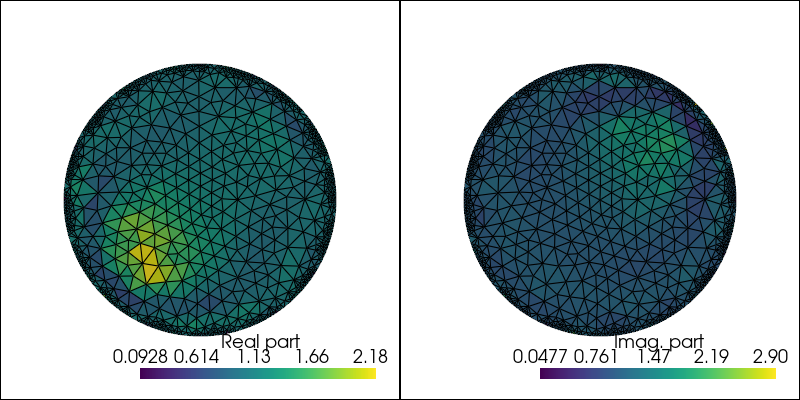

In [23]:
eitx.plot_indicator_function(gamma)